In [1]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [2]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Cleaning the data

In [3]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [6]:
df.fillna(modes, inplace=True)

In [7]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [8]:
import numpy as np

df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


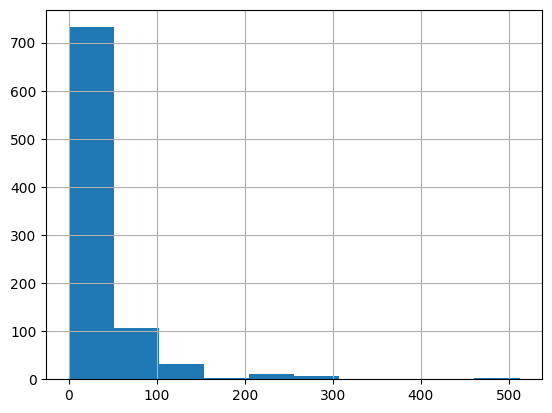

In [9]:
df['Fare'].hist();

In [10]:
df['LogFare'] = np.log(df['Fare']+1)

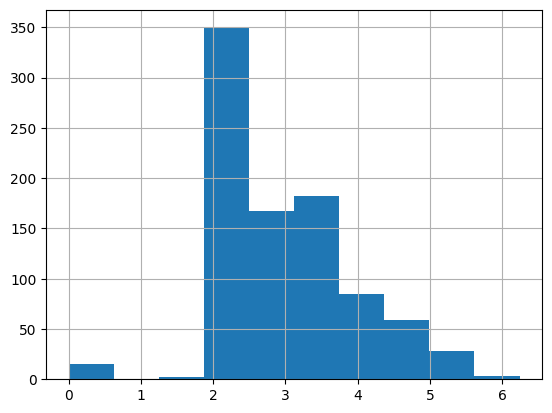

In [11]:
df['LogFare'].hist();

In [12]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [13]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [14]:
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [15]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,True,False,False,False,True,False,False,True
1,False,True,True,False,False,True,False,False
2,False,True,False,False,True,False,False,True
3,False,True,True,False,False,False,False,True
4,True,False,False,False,True,False,False,True


In [16]:
from torch import tensor

t_dep = tensor(df.Survived)

In [17]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
df[indep_cols] = df[indep_cols].apply(lambda col: col.astype(int) if col.dtypes == 'bool' else col)
t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [18]:
t_indep.shape

torch.Size([891, 12])

## Setting up a linear model

In [19]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [20]:
t_indep*coeffs # multiply matrix with vector, this is element wise multiplication (broadcasting)

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.2632,  -0.0000,   0.0000

In [21]:
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals # normalisieren, element wise division

In [22]:
preds = (t_indep*coeffs).sum(axis=1)

In [23]:
preds[:10]

tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

In [24]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5382)

In [25]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

## Doing a gradient descent step

In [26]:
coeffs.requires_grad_() # underscore at the end -> inplace operation

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [27]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

In [28]:
loss.backward()

In [29]:
coeffs.grad # tells you what happens tpo the loss when you increase the coefficient

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

In [30]:
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5197)


##  Train the linear model

In [31]:
from sklearn.model_selection import train_test_split

trn_indep, val_indep, trn_dep, val_dep = train_test_split(
    t_indep, 
    t_dep, 
    test_size=0.2,
    random_state=42,
)

In [32]:
def update_coeffs(coeffs, lr): coeffs.sub_(coeffs.grad * lr)

In [33]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [34]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_() # torch.rand creates random numbers between 0 and 1

In [35]:
def train_model(epochs=30,lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

In [36]:
coeffs = train_model(lr=0.2)

0.526; 0.495; 0.476; 0.395; 0.338; 0.289; 0.334; 0.400; 0.442; 0.447; 0.405; 0.393; 0.351; 0.394; 0.366; 0.402; 0.433; 0.451; 0.445; 0.435; 0.446; 0.456; 0.457; 0.469; 0.445; 0.385; 0.295; 0.378; 0.387; 0.475; 

In [37]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.0962),
 'SibSp': tensor(-0.3585),
 'Parch': tensor(-0.1989),
 'LogFare': tensor(0.1710),
 'Sex_male': tensor(-0.4922),
 'Sex_female': tensor(0.2361),
 'Pclass_1': tensor(0.5716),
 'Pclass_2': tensor(-0.0968),
 'Pclass_3': tensor(0.9282),
 'Embarked_C': tensor(0.2195),
 'Embarked_Q': tensor(0.2552),
 'Embarked_S': tensor(-0.0192)}

## Measuring accuracy

In [38]:
preds = calc_preds(coeffs, val_indep)

In [39]:
results = val_dep.bool()==(preds>0.5) # copare actual and predction
results[:16]

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True,  True,  True, False, False,  True,  True])

In [40]:
results.float().mean() # accuracy

tensor(0.6816)

In [41]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.6816)

## Using sigmoid

In [42]:
preds[:28]

tensor([ 0.6251, -0.5786,  0.4527,  0.1763,  1.3908,  0.8772,  1.4501,  0.3886,  1.4597,  0.7899,  0.0802,  0.4242,  1.0384,  0.6772,
        -0.5792,  0.8374,  0.0739,  1.4504, -0.5684,  0.1125,  0.4478,  0.1102,  1.1372,  0.4564,  0.4630,  0.2962,  0.3429, -0.5732])

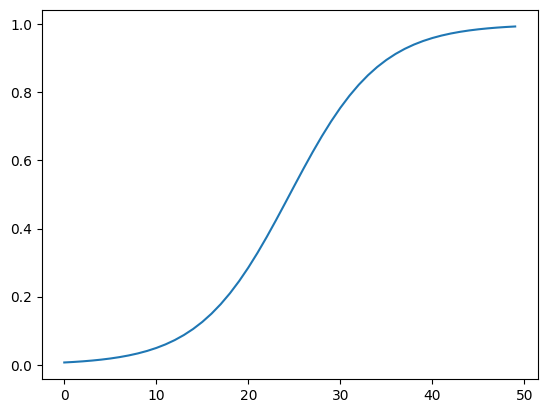

In [43]:
sigmoid = lambda x: (1/(1+np.exp(-x)))
x = sigmoid(np.linspace(-5,5,50))
import matplotlib.pyplot as plt
plt.plot(x);

In [44]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [45]:
coeffs = train_model(lr=2)

0.512; 0.469; 0.396; 0.338; 0.308; 0.287; 0.266; 0.244; 0.224; 0.211; 0.204; 0.200; 0.198; 0.197; 0.197; 0.198; 0.198; 0.198; 0.198; 0.198; 0.197; 0.197; 0.196; 0.194; 0.193; 0.191; 0.190; 0.188; 0.187; 0.186; 

In [46]:
acc(coeffs)

tensor(0.7933)

In [47]:
show_coeffs()

{'Age': tensor(-1.0444),
 'SibSp': tensor(-1.5258),
 'Parch': tensor(-0.2144),
 'LogFare': tensor(1.7212),
 'Sex_male': tensor(-19.1594),
 'Sex_female': tensor(16.4982),
 'Pclass_1': tensor(7.2695),
 'Pclass_2': tensor(4.9722),
 'Pclass_3': tensor(-13.2439),
 'Embarked_C': tensor(3.3664),
 'Embarked_Q': tensor(0.9411),
 'Embarked_S': tensor(-6.2571)}

## Submitting to Kaggle

In [48]:
tst_df = pd.read_csv(path/'test.csv')

In [49]:
tst_df['Fare'] = tst_df.Fare.fillna(0)

In [50]:
tst_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [51]:
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])
tst_df[indep_cols] = tst_df[indep_cols].apply(lambda col: col.astype(int) if col.dtypes == 'bool' else col)

tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals

In [52]:
tst_df['Survived'] = (calc_preds(tst_indep, coeffs)>0.5).int()

In [53]:
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('submission.csv', index=False)

In [54]:
!head submission.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


## Using matrix product

In [55]:
(val_indep*coeffs).sum(axis=1)

tensor([-28.8078, -20.1754, -38.3178,  16.0718,   6.9380,  18.3792,   4.4803, -38.4386,   4.5847,  18.1029, -17.7201, -38.6273,  -3.0206,
        -28.8473, -20.1864,  18.2861, -17.7881,   4.4828, -20.0689, -17.6655, -38.3709, -17.6763,  -2.8401, -38.2803, -38.2178, -38.5068,
         -8.1196, -20.1211, -38.4285,  -2.8061, -38.3056,  -2.6918,  -7.8835,  -2.7243, -38.2878, -28.8250, -17.5204,   4.4803,  27.6983,
        -38.3709, -19.9110, -38.6546, -38.3662, -31.1773,   6.7526, -38.1837, -38.2976, -38.3195, -38.3985,  -8.0452,   6.9680,  17.8598,
        -38.5885, -17.2301, -31.7125,  18.4149, -20.1884,  27.9668,  15.6089,   4.5496, -38.3355,  15.8409,  15.5660, -17.5521, -31.1773,
         15.1428, -19.5295, -38.4368, -28.9040,  27.4705,  15.5564,  27.9834,  -7.9158,  27.6210, -38.3592, -38.5471,   4.3954,  27.8571,
         15.4450,  -2.7671, -38.6458,  15.5083,  27.7393, -31.1777,  -8.3013,  -8.3686,  27.8456,  27.8620, -18.6430, -38.3917, -38.0029,
         -2.9965, -17.9763, -31.17

In [56]:
val_indep@coeffs

tensor([-28.8078, -20.1754, -38.3178,  16.0718,   6.9380,  18.3792,   4.4803, -38.4386,   4.5847,  18.1029, -17.7201, -38.6273,  -3.0206,
        -28.8473, -20.1864,  18.2861, -17.7881,   4.4828, -20.0689, -17.6655, -38.3709, -17.6763,  -2.8401, -38.2803, -38.2178, -38.5068,
         -8.1196, -20.1211, -38.4285,  -2.8061, -38.3056,  -2.6918,  -7.8835,  -2.7243, -38.2878, -28.8250, -17.5204,   4.4803,  27.6983,
        -38.3709, -19.9110, -38.6546, -38.3662, -31.1773,   6.7526, -38.1837, -38.2976, -38.3195, -38.3985,  -8.0452,   6.9680,  17.8598,
        -38.5885, -17.2301, -31.7125,  18.4149, -20.1884,  27.9668,  15.6089,   4.5496, -38.3355,  15.8409,  15.5660, -17.5521, -31.1773,
         15.1428, -19.5295, -38.4368, -28.9040,  27.4705,  15.5564,  27.9834,  -7.9158,  27.6210, -38.3592, -38.5471,   4.3954,  27.8571,
         15.4450,  -2.7671, -38.6458,  15.5083,  27.7393, -31.1777,  -8.3013,  -8.3686,  27.8456,  27.8620, -18.6430, -38.3917, -38.0029,
         -2.9965, -17.9763, -31.17

In [57]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

In [58]:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_() # now this is a matrix as well

In [59]:
trn_dep = trn_dep[:,None] # this notation in pytorch/numpy creates the next dimension from vector to a matrix
val_dep = val_dep[:,None]

In [60]:
trn_dep.shape

torch.Size([712, 1])

In [61]:
coeffs = train_model(lr=100)

0.513; 0.322; 0.324; 0.324; 0.322; 0.311; 0.278; 0.267; 0.232; 0.208; 0.208; 0.208; 0.208; 0.207; 0.205; 0.202; 0.200; 0.198; 0.198; 0.198; 0.198; 0.198; 0.198; 0.198; 0.198; 0.198; 0.198; 0.197; 0.195; 0.188; 

In [62]:
acc(coeffs)

tensor(0.7933)

## A neural network

In [63]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden # to make gradients smaller, every coefficient has n_hidden cols now
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0] # no constant term for the first layer (because dummys have n cols rather than n-1) # Layer 2 needs a constant term
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

In [64]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

In [65]:
def update_coeffs(coeffs, lr): # for every set of coeffs the gradients need to be adjusted
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [66]:
coeffs = train_model(lr=1.4)

0.544; 0.533; 0.520; 0.505; 0.487; 0.464; 0.436; 0.403; 0.369; 0.337; 0.313; 0.294; 0.279; 0.267; 0.257; 0.249; 0.243; 0.238; 0.234; 0.231; 0.228; 0.225; 0.223; 0.221; 0.220; 0.218; 0.217; 0.215; 0.214; 0.213; 

In [67]:
acc(coeffs)

tensor(0.7989)

## Deep Learning

In [68]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1] # n_coeffs,10 -> 10,10 -> 10,1
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [69]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

In [70]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [71]:
coeffs = train_model(lr=1.4)

0.522; 0.463; 0.365; 0.319; 0.270; 0.239; 0.227; 0.219; 0.214; 0.211; 0.208; 0.205; 0.203; 0.201; 0.199; 0.198; 0.197; 0.195; 0.195; 0.194; 0.193; 0.192; 0.192; 0.191; 0.191; 0.190; 0.190; 0.190; 0.189; 0.189; 

In [72]:
acc(coeffs)

tensor(0.7933)